# Iterative results

In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR


from fault_management_uds.config import rain_gauge_color, condition_to_meta
from fault_management_uds.synthetic.synthetic_generator import find_unterrupted_sequences
from fault_management_uds.plots import visualize_indicator_dict, get_timing
from fault_management_uds.plots import pca_plot, visualize_metric_matrix, visualize_confusion, visualize_roc_auc




2025-01-31 17:16:40.493 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds
2025-01-31 17:16:41.616883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 17:16:42.065831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738340202.109140 1374278 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738340202.121674 1374278 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
20

In [2]:
indicator_2_data_label = json.load(open(REFERENCE_DIR / 'indicator_2_data_label.json', 'r'))

figures_folder = FIGURES_DIR / 'iterative'
os.makedirs(figures_folder, exist_ok=True)

In [3]:
data_type = "test" # ["train", "val", "test"]

# load iterations folders
save_folder = "transformer/7_anomalous"
save_folder = MODELS_DIR / save_folder
prefix = "combined_iteration="

relative_path = "1_split/anomalous"

filename = 'anomaly_prediction_results.pkl'


colormap = {
    0: 'blanchedalmond',
    1: 'slateblue',
}

hue_map = {
    'Overall': 'blanchedalmond', 
    'Spike': 'OrangeRed',
    'Noise': 'DarkGray',
    'Frozen': 'SteelBlue',
    'Offset': 'Gold',
    'Drift': 'LightSeaGreen',
}
hue_order = list(hue_map.keys())[::-1]

In [4]:
def extract_outputs(outputs):

    # get the model predictions

    idx_pred_0 = outputs['0']
    label_0 = np.zeros(len(idx_pred_0), dtype=int)
    idx_pred_1 = outputs['1']
    label_1 = np.ones(len(idx_pred_1), dtype=int)

    # align these predictions with the true labels
    idx_pred = np.concatenate((idx_pred_0, idx_pred_1))
    label_pred = np.concatenate((label_0, label_1))

    # sort the predictions
    sort_indices = np.argsort(idx_pred)
    idx_pred = idx_pred[sort_indices]
    label_pred = label_pred[sort_indices]

    decision_function = outputs["decision_function"]


    # get the true labels
    data_label = outputs["data_label"]
    actual = np.array([int(dl != 'Original') for dl in data_label])



    return label_pred, decision_function, actual, data_label
#idx_pred, label_pred, decision_function, true, data_label

In [5]:
runs = os.listdir(save_folder)
runs = [run for run in runs if run.startswith(prefix)]
n_iterations = len(runs)
print(f"Highest iteration: {n_iterations}")
print(runs)
print('')
combined_results = {}

iterations = []
iter_names = []
for run in runs:
    print(f"Run: {run}")
    iteration = run.split("=")[1]
    iter_name = f"Iteration {iteration}"
    combined_results[iter_name] = {}

    # load the outputs file
    outputs_file = save_folder / run / data_type / filename
    #/ relative_path / data_type / filename
    outputs = pd.read_pickle(outputs_file)

    label_pred, decision_function, actual, data_label = extract_outputs(outputs)
    # combined results
    combined_results[iter_name] = {
        "label_pred": label_pred,
        "decision_function": decision_function,
        "actual": actual,
        "data_label": data_label
    }



    iterations.append(iteration)
    iter_names.append(iter_name)

# sort
iterations = sorted(iterations)
iter_names = sorted(iter_names)


Highest iteration: 3
['combined_iteration=2', 'combined_iteration=0', 'combined_iteration=1']

Run: combined_iteration=2
Run: combined_iteration=0
Run: combined_iteration=1


In [6]:
# get results for each iteration

runs = os.listdir(save_folder)
prefix = "iteration="
runs = [run for run in runs if run.startswith(prefix)]
print(f"Total: {len(runs)}")
# take ceil of log2 of the number of runs to get the highest iteration
n_iterations = int(np.ceil(np.log2(len(runs))))
print(f"Highest iteration: {n_iterations}")
print(runs)
results = {}
for run in runs:
    # get the iteration number
    iteration_identifier = run.split("=")[-1].split("_")[0]
    n_iteration = len(iteration_identifier.split("."))
    # if n_iteration > 2:
    #     # go to next iteration
    #     continue
    print(f"Iteration identifier: {iteration_identifier}")
    print(f"Number of iteration: {n_iteration}")

    # load the outputs file
    outputs_file = save_folder / run / relative_path / data_type / filename
    outputs = pd.read_pickle(outputs_file)
    label_pred, decision_function, actual, data_label = extract_outputs(outputs)
    results[iteration_identifier] = {
        "label_pred": label_pred,
        "decision_function": decision_function,
        "actual": actual,
        "data_label": data_label
    }
    print('')
    


Total: 7
Highest iteration: 3
['iteration=0_250106_0752', 'iteration=0.1_250107_1455', 'iteration=0.1.0_250108_2222', 'iteration=0.0.1_250108_2105', 'iteration=0.0_250107_1459', 'iteration=0.1.1_250108_2117', 'iteration=0.0.0_250108_2052']
Iteration identifier: 0
Number of iteration: 1

Iteration identifier: 0.1
Number of iteration: 2

Iteration identifier: 0.1.0
Number of iteration: 3

Iteration identifier: 0.0.1
Number of iteration: 3

Iteration identifier: 0.0
Number of iteration: 2

Iteration identifier: 0.1.1
Number of iteration: 3

Iteration identifier: 0.0.0
Number of iteration: 3



In [7]:
# create a combined results where it is not iterations, concatenate the results
ano_pred_timeline = {}
iter_to_keys = {}
iter_keys = list(results.keys())
for iteration in iterations:
    iter_name = f"Iteration {iteration}"
    print(f"Iteration: {iteration}")
    # find relevant keys
    relevant_keys = [key for key in iter_keys if len(key.split(".")) == int(iteration)+1]
    # sort keys so that 0 then 1
    relevant_keys = sorted(relevant_keys)
    iter_to_keys[iteration] = relevant_keys
    print(f"Relevant keys: {relevant_keys}")
    # concatenate the results
    #combined_results[iteration] = {}
    ano_pred_timeline[iter_name] = {
        'colormap': colormap,
    }
    for key in relevant_keys:
        # create timeline data: sort label_pred
        ano_pred_timeline[iter_name]['indicator'] = np.concatenate((ano_pred_timeline[iter_name].get('indicator', []), sorted(results[key]["label_pred"])))


Iteration: 0
Relevant keys: ['0']
Iteration: 1
Relevant keys: ['0.0', '0.1']
Iteration: 2
Relevant keys: ['0.0.0', '0.0.1', '0.1.0', '0.1.1']


## The data split sizes

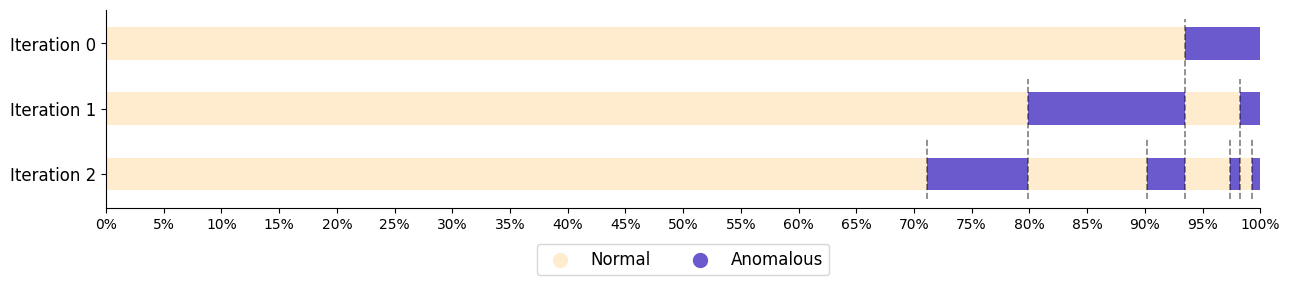

In [9]:
# indicator plot
fig, ax = plt.subplots(figsize=(13, 3)) 

# predicted anomalies in each subset
ax = visualize_indicator_dict(ax, ano_pred_timeline, start=None, end=None, adjust='half-point', ylabel='')
ax.set_xlim(0, len(ano_pred_timeline['Iteration 1']['indicator']))
total_length = len(ano_pred_timeline['Iteration 1']['indicator'])
xticks = np.linspace(0, total_length - 1, num=21, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(x / total_length * 100)}%" for x in xticks])
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)#; ax.spines['left'].set_visible(False)
# increase y-ticks font size
ax.tick_params(axis='y', labelsize=12)


ymin, ymax = ax.get_ylim()
diff_step = abs(ymax - ymin) / len(iterations)
ignore = [-100] # dummy value to not be empty
for iteration in iterations:    
    # find the indices where we go from 0 to 1 or 1 to 0
    indices = np.where(np.diff(ano_pred_timeline['Iteration ' + iteration]['indicator']) != 0)[0]
    # show decision boundaries
    i=0
    for idx in indices:
        if min([abs(idx - x) for x in ignore]) < 10:
            continue
        _ymin = ymin
        _ymax = ymax + int(iteration) * diff_step
        ax.vlines(idx, 
                  _ymin, _ymax, 
                  color='black', linestyle='--', alpha=0.5, linewidth=1.2)
        ignore.append(idx)
        i += 1
        
# add legend based on colormap
for i, (key, value) in enumerate(colormap.items()):
    ax.scatter([], [], color=value, label=str(key).replace('0', 'Normal').replace('1', 'Anomalous'), s=100)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), ncol=len(colormap), fontsize=12)

plt.tight_layout()
plt.savefig(figures_folder / f'anomaly_timeline_{data_type}.png', dpi=150)
plt.show()

## Error matrices

In [10]:
len(actual), len(label_pred), len(data_label)

(692052, 692052, 692052)

In [11]:
combined_results.keys()

dict_keys(['Iteration 2', 'Iteration 0', 'Iteration 1'])

Iteration: Iteration 0


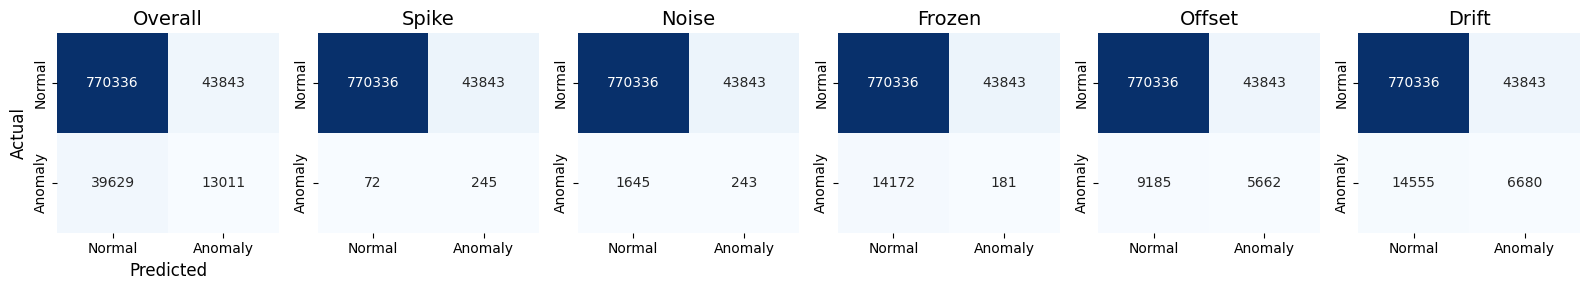

Iteration: Iteration 1


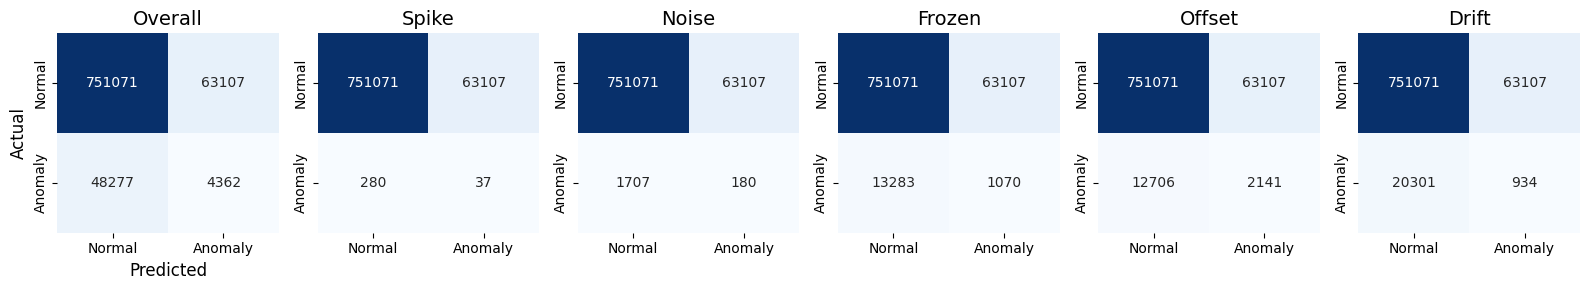

Iteration: Iteration 2


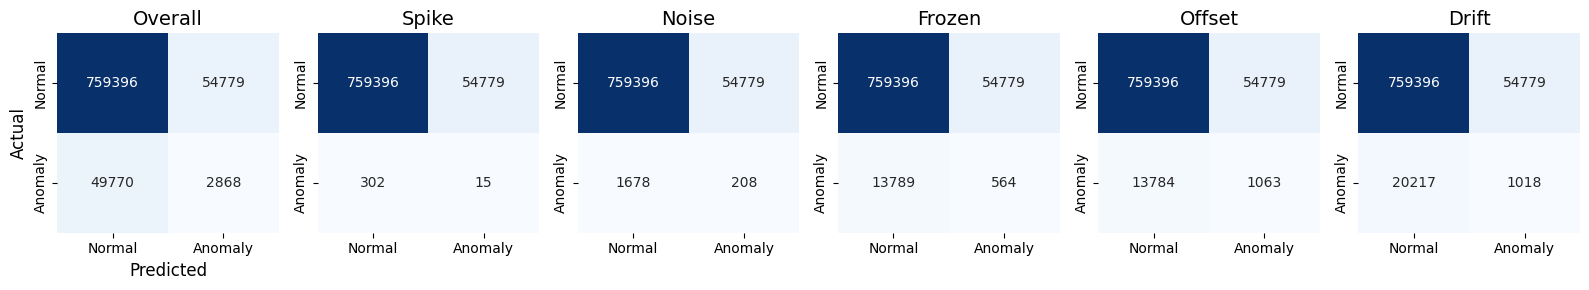

In [12]:
n_rows = len(combined_results)
n_cols = len(hue_order)
# create subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

for i, iteration in enumerate(sorted(list(combined_results.keys()))):
    fig, axes = plt.subplots(1, n_cols, figsize=(16, 3))
    actual = combined_results[iteration]['actual']
    data_label = combined_results[iteration]['data_label']
    pred_label = combined_results[iteration]['label_pred']  
    for j, label in enumerate(hue_order[::-1]):
        if label == 'Overall':
            # set mask to all the data
            mask = np.ones(len(actual), dtype=bool)
        else:
             # set mask to the label and original
             mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')

        conf_matrix = confusion_matrix(actual[mask], pred_label[mask])
        axes[j] = visualize_confusion(axes[j], j, label, conf_matrix, 'd', 'Blues')

    # set title for the entire row
    #fig.suptitle(iteration, fontsize=15, x=0.5, y=1.05)  # Adjust x and y for centering
    print(f"Iteration: {iteration}")
    plt.tight_layout()
    plt.savefig(figures_folder / f'confusion_matrix_{iteration}_{data_type}.png', dpi=150)
    plt.show()


## The AUC scores

Iteration: Iteration 0


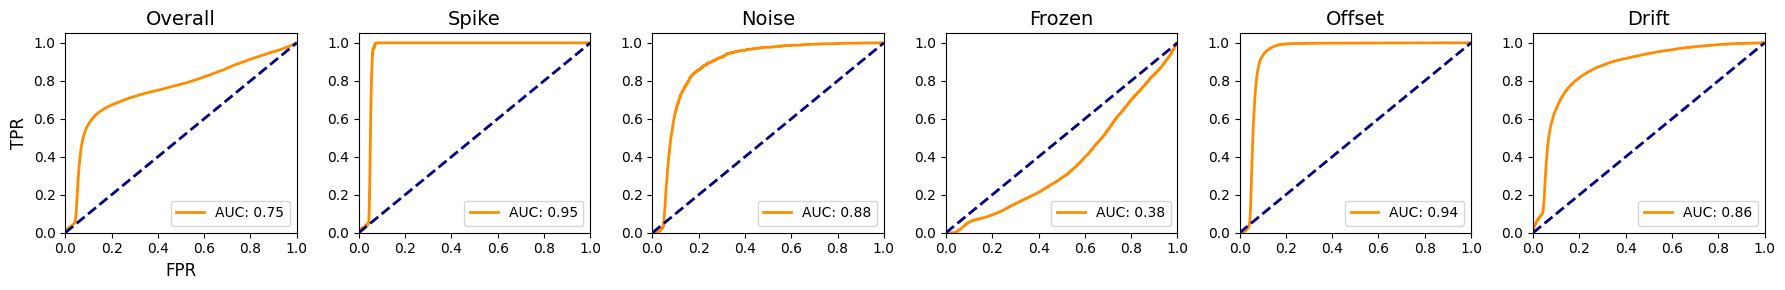

Iteration: Iteration 1


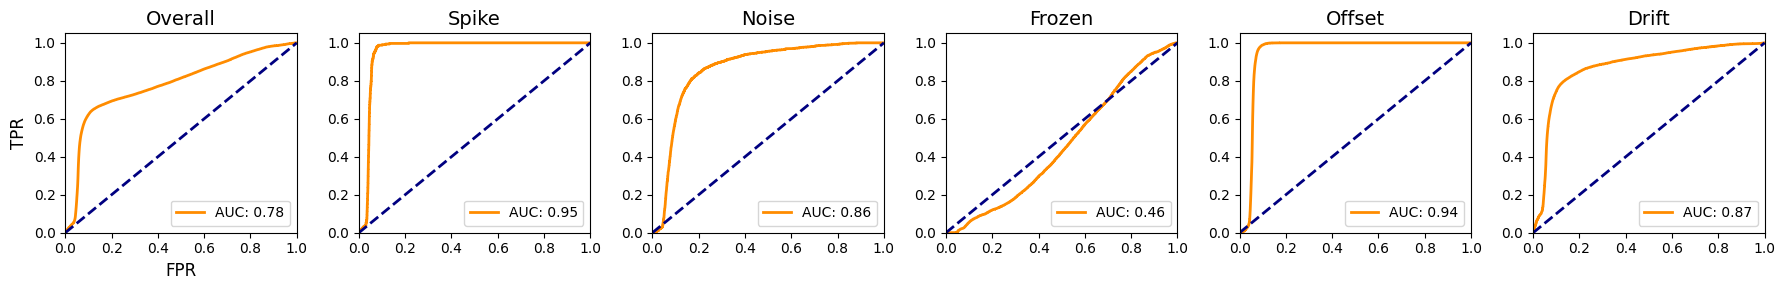

Iteration: Iteration 2


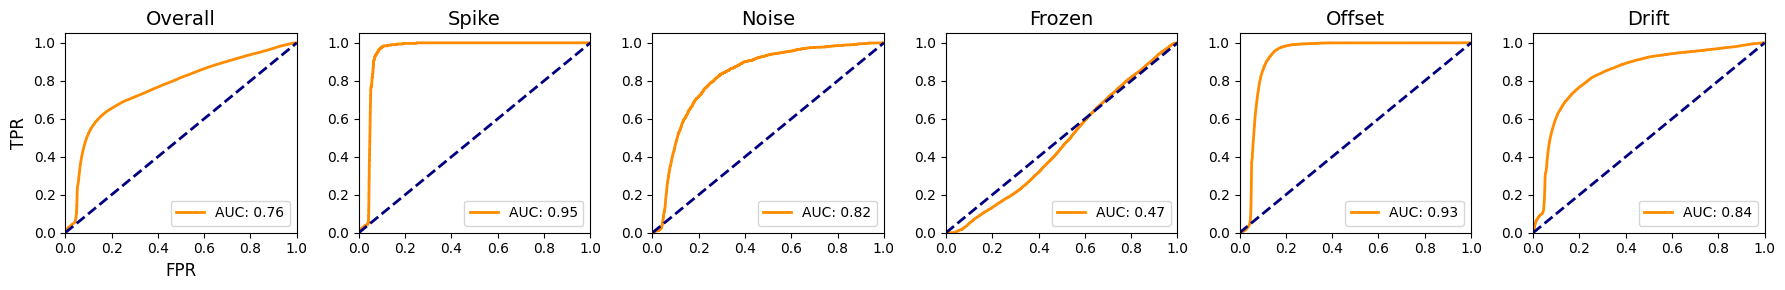

In [13]:
n_rows = len(combined_results)
n_cols = len(hue_order)
# create subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

auc_dict = {}
for i, iteration in enumerate(sorted(list(combined_results.keys()))):
    auc_dict[iteration] = {}
    fig, axes = plt.subplots(1, n_cols, figsize=(18, 3))
    actual = combined_results[iteration]['actual']
    data_label = combined_results[iteration]['data_label']
    decision_function = combined_results[iteration]['decision_function'] 
    for j, label in enumerate(hue_order[::-1]):
        if label == 'Overall':
            # set mask to all the data
            mask = np.ones(len(actual), dtype=bool)
        else:
             # set mask to the label and original
             mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')

        #print(f'Anomaly: {label}')
        # ROC curve
        fpr, tpr, _ = roc_curve(actual[mask], decision_function[mask])
        roc_auc = auc(fpr, tpr)
        auc_dict[iteration][label] = roc_auc
        # def visualize_roc_auc(ax, i, key, fpr, tpr, roc_auc):
        axes[j] = visualize_roc_auc(axes[j], j, label, fpr, tpr, roc_auc)
    # set title for the entire row
    #fig.suptitle(iteration, fontsize=15, x=0.5, y=1.05)  # Adjust x and y for centering
    print(f"Iteration: {iteration}")
    plt.tight_layout()
    plt.savefig(figures_folder / f'roc_auc_{iteration}_{data_type}.png', dpi=150)
    plt.show()

auc_df = pd.DataFrame(auc_dict)

## Matrix of AUC

In [14]:
row_order = hue_order[1:] + ['Average', 'Overall']

In [15]:
# Calculate the average AUC as well
auc_df.loc['Average'] = auc_df.loc[hue_order[1:]].mean()
# reorder the rows
auc_df = auc_df.loc[row_order]
auc_df = auc_df.T
# inverse the order of the rows
auc_df = auc_df.iloc[::-1]
# inverse order of the columns
auc_df = auc_df.iloc[:, ::-1]

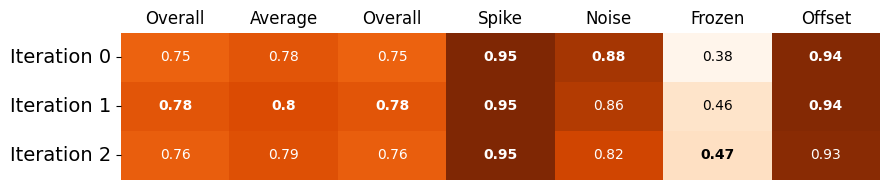

In [16]:
visualize_metric_matrix(
    'roc_auc',
    auc_df, 
    'Oranges', 2, suffix=None,
    high_best=True,
    figsize=(9, 2), 
    save_folder=None,#figures_folder,
    top_n_bold=0,
    annotate_row_wise=False,
    ysize=14

)

## Matrix of metrics

rows are iterations, columns are metrics

In [17]:
results_dict = {}

for i, iteration in enumerate(sorted(list(combined_results.keys()))):
    results_dict[iteration] = {}
    # calculate all the metrics
    label_pred = combined_results[iteration]['label_pred']
    decision_function = combined_results[iteration]['decision_function']
    actual = combined_results[iteration]['actual']

    # AUC
    fpr, tpr, _ = roc_curve(actual, decision_function)
    roc_auc = auc(fpr, tpr)
    results_dict[iteration]['AUC'] = roc_auc
    # Precision
    results_dict[iteration]['Precision'] = precision_score(actual, label_pred)
    # Recall
    results_dict[iteration]['Recall'] = recall_score(actual, label_pred)
    # TODO: timing
    indices_of_ones = [index for index, value in enumerate(actual) if value == 1]
    _, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)
    results_dict[iteration]['Timing'] = np.mean(get_timing(label_pred, anomaly_start_end))


results_df = pd.DataFrame(results_dict).T
# inverse the order of the iterations
results_df = results_df.iloc[::-1]

Stopping with 1 anomalies left
Stopping with 1 anomalies left


In [18]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap that is completely white
custom_cmap = LinearSegmentedColormap.from_list("white_cmap", ["white", "white"], N=256)


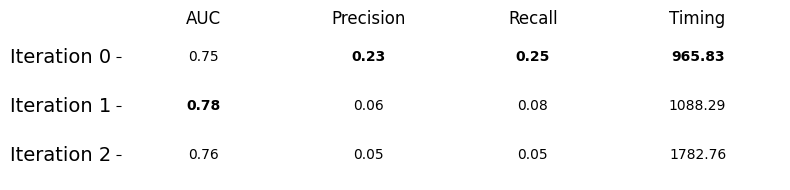

In [19]:
visualize_metric_matrix('all_metrics', results_df, custom_cmap, 2, suffix=None, 
                        high_best=[True, True, True, False],
                        figsize=(8, 2), save_folder=figures_folder,
                        top_n_bold=0,
                        annotate_row_wise=False, 
                        ysize=14
)
visualize_metric_matrix('all_metrics', results_df, custom_cmap, 2, suffix=None, 
                        high_best=[True, True, True, False],
                        figsize=(8, 2), save_folder=None,
                        top_n_bold=0,
                        annotate_row_wise=False, 
                        ysize=14
)


## TODO:

- How do the other indicators work?